Utilizando dispositivo: cuda
GENERACIÓN DE TEXTO CON REDES NEURONALES RECURRENTES (LSTM)
Inicializando procesador de texto...
Cargando texto desde: don-quijote-de-la-mancha.txt
Texto cargado correctamente. Longitud: 2071198 caracteres
Procesador de texto inicializado correctamente.
Calculando estadísticas del texto...

--- ESTADÍSTICAS DEL TEXTO ---
Total de caracteres: 2071198
Tamaño del vocabulario: 61
Total de palabras: 376500
Palabras únicas: 37269
Longitud media de palabra: 4.48 caracteres

Palabras más comunes:
  que: 19273
  de: 17892
  y: 16290
  la: 10201
  a: 9641
  el: 8036
  en: 8019
  no: 5706
  los: 4688
  se: 4643

Caracteres más comunes:
  [espacio]: 348116
  e: 219239
  a: 191124
  o: 151442
  s: 124229
  n: 107074
  r: 99644
  l: 88000
  d: 86194
  u: 77257


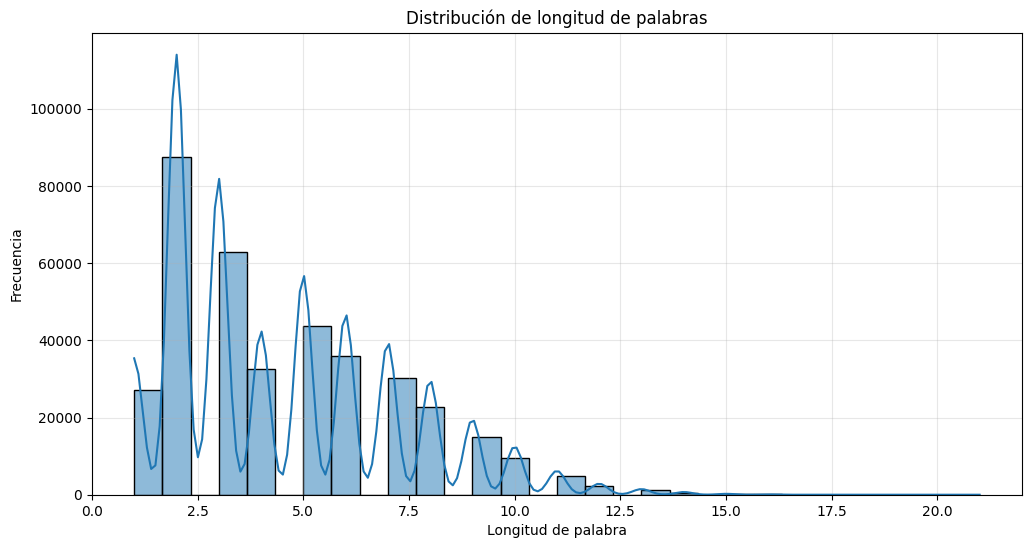

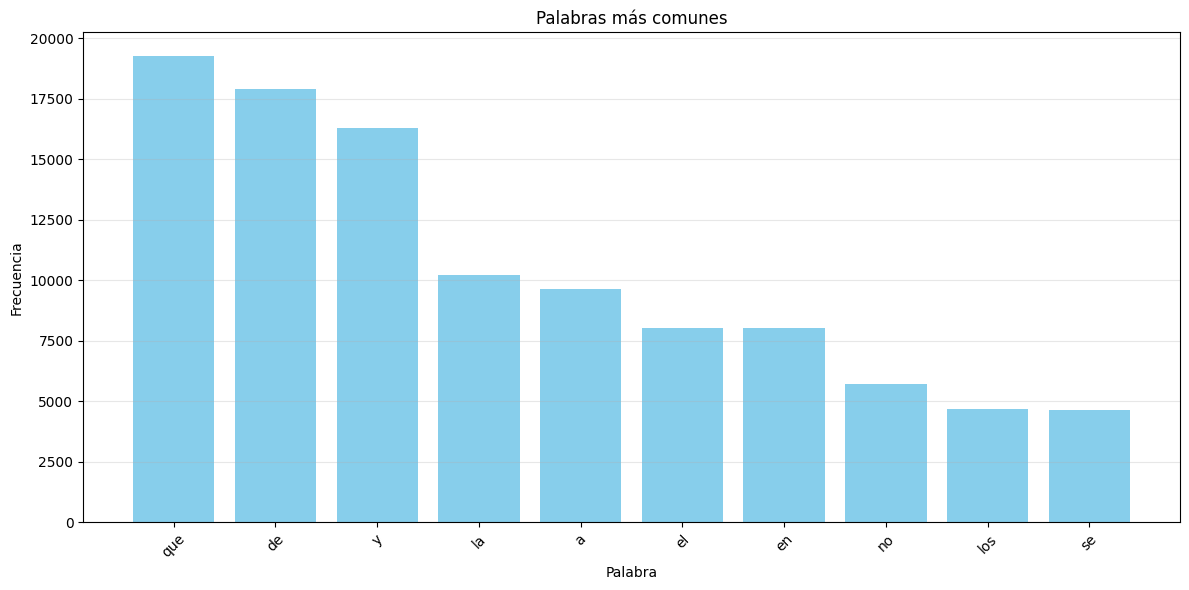


PREPARACIÓN DE DATOS
Creando secuencias de entrenamiento con longitud 50...
Se han creado 2071148 secuencias de entrenamiento.
Codificando secuencias en formato one-hot...
Codificación completada. Forma de X: (2071148, 50, 61), Forma de y: (2071148, 61)
Datos preparados y cargados en DataLoader.

CREACIÓN Y ENTRENAMIENTO DEL MODELO
Arquitectura del modelo:
  - Tamaño de entrada: 61
  - Tamaño de capa oculta: 256
  - Número de capas LSTM: 2
  - Tamaño de salida: 61
  - Batch size: 128
  - Épocas: 20
  - Tasa de aprendizaje: 0.001

Resumen del modelo:
  - Parámetros totales: 868,669
  - Parámetros entrenables: 868,669

INICIANDO ENTRENAMIENTO
Configurando entrenamiento...
Entrenamiento configurado. Total de batches por época: 16181
Época 1/20:
[====================] 100.0%
Época 1/20 completada en 471.85 segundos. Pérdida: 0.0392
Época 2/20:
[====================] 100.0%
Época 2/20 completada en 447.13 segundos. Pérdida: 0.0331
Época 3/20:
[====================] 100.0%
Época 3/20 comple

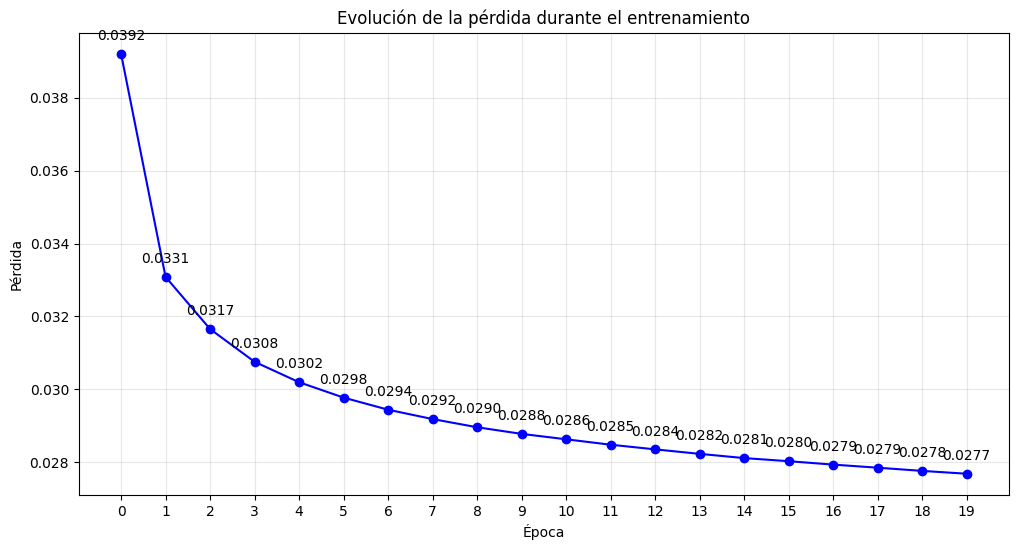

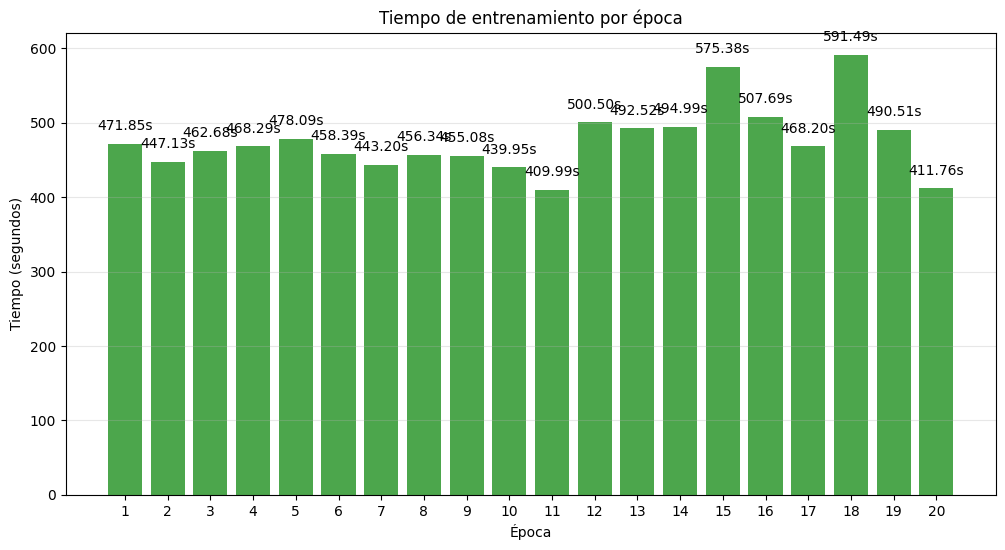


GENERACIÓN DE TEXTO

Generando texto con temperatura 0.2:
Generando texto a partir de la semilla: 'en un lugar de la mancha'
Temperatura: 0.2 (menor = más determinista, mayor = más aleatorio)
Progreso de generación:
[====================] 100.0%
Generación de texto completada.

Fragmento del texto generado (primeros 200 caracteres):
en un lugar de la mancha, y al parecer de la mano, y aun se le había de dejar de ver en la mano de la mano, y el cura de la cabeza de la mano, y que esto es la cabeza de la mano, y que el caballero de...
Texto completo guardado en 'texto_generado_temp_0.2.txt'

Generando texto con temperatura 0.5:
Generando texto a partir de la semilla: 'en un lugar de la mancha'
Temperatura: 0.5 (menor = más determinista, mayor = más aleatorio)
Progreso de generación:
[====================] 100.0%
Generación de texto completada.

Fragmento del texto generado (primeros 200 caracteres):
en un lugar de la mancha y alguna tan alta condición y en casa de los que le llevaban, y

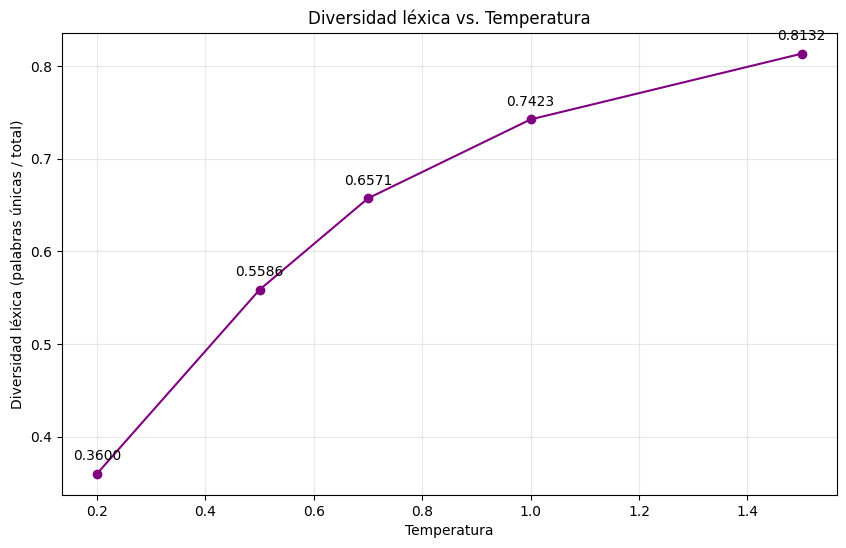


PROCESO COMPLETADO

Tiempo total de ejecución: 159 minutos y 59.87 segundos


In [1]:
# Importación de librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import time
from colorama import Fore, Style, init

# Inicializar colorama para colores en la terminal
init(autoreset=True)

# Verificar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{Fore.CYAN}Utilizando dispositivo: {Fore.YELLOW}{device}{Style.RESET_ALL}")

# Clase para procesar y preparar el texto
class TextProcessor:
    def __init__(self, file_path):
        """
        Inicializa el procesador de texto
        Args:
            file_path: Ruta al archivo de texto
        """
        print(f"{Fore.GREEN}Inicializando procesador de texto...{Style.RESET_ALL}")
        self.file_path = file_path
        self.text = self.load_text()
        self.chars = sorted(list(set(self.text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)
        print(f"{Fore.GREEN}Procesador de texto inicializado correctamente.{Style.RESET_ALL}")
        
    def load_text(self):
        """
        Carga y limpia el texto del archivo
        Returns:
            str: Texto limpio
        """
        try:
            print(f"{Fore.BLUE}Cargando texto desde: {self.file_path}{Style.RESET_ALL}")
            with open(self.file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            
            # Limpieza básica del texto
            text = text.lower()
            # Eliminar caracteres no deseados si es necesario
            # text = re.sub(r'[^\w\s]', '', text)
            
            print(f"{Fore.GREEN}Texto cargado correctamente. Longitud: {len(text)} caracteres{Style.RESET_ALL}")
            return text
        except Exception as e:
            print(f"{Fore.RED}Error al cargar el archivo: {e}{Style.RESET_ALL}")
            return ""
    
    def get_stats(self):
        """
        Obtiene estadísticas básicas del texto
        Returns:
            dict: Diccionario con estadísticas
        """
        print(f"{Fore.BLUE}Calculando estadísticas del texto...{Style.RESET_ALL}")
        words = self.text.split()
        word_count = len(words)
        unique_words = len(set(words))
        char_count = len(self.text)
        
        # Palabras más comunes
        word_counter = Counter(words)
        most_common_words = word_counter.most_common(10)
        
        # Longitud de palabras
        word_lengths = [len(word) for word in words]
        avg_word_length = sum(word_lengths) / len(word_lengths)
        
        # Frecuencia de caracteres
        char_counter = Counter(self.text)
        most_common_chars = char_counter.most_common(10)
        
        return {
            "total_chars": char_count,
            "vocab_size": self.vocab_size,
            "total_words": word_count,
            "unique_words": unique_words,
            "most_common_words": most_common_words,
            "avg_word_length": avg_word_length,
            "most_common_chars": most_common_chars,
            "word_lengths": word_lengths,
            "word_counter": word_counter
        }
    
    def create_sequences(self, seq_length):
        """
        Crea secuencias de entrenamiento de longitud fija
        Args:
            seq_length: Longitud de cada secuencia
        Returns:
            tuple: (X, y) donde X son las secuencias de entrada y y son los objetivos
        """
        print(f"{Fore.BLUE}Creando secuencias de entrenamiento con longitud {seq_length}...{Style.RESET_ALL}")
        sequences = []
        next_chars = []
        
        for i in range(0, len(self.text) - seq_length):
            sequences.append(self.text[i:i + seq_length])
            next_chars.append(self.text[i + seq_length])
        
        print(f"{Fore.GREEN}Se han creado {len(sequences)} secuencias de entrenamiento.{Style.RESET_ALL}")
        
        # Convertir a índices
        print(f"{Fore.BLUE}Codificando secuencias en formato one-hot...{Style.RESET_ALL}")
        X = np.zeros((len(sequences), seq_length, self.vocab_size), dtype=np.bool_)
        y = np.zeros((len(sequences), self.vocab_size), dtype=np.bool_)
        
        for i, sequence in enumerate(sequences):
            for t, char in enumerate(sequence):
                X[i, t, self.char_to_idx[char]] = 1
            y[i, self.char_to_idx[next_chars[i]]] = 1
        
        print(f"{Fore.GREEN}Codificación completada. Forma de X: {X.shape}, Forma de y: {y.shape}{Style.RESET_ALL}")
        
        return torch.FloatTensor(X), torch.FloatTensor(y)

# Clase de conjunto de datos personalizado para PyTorch
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Modelo LSTM para generación de texto
class TextGenerationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        """
        Inicializa el modelo de generación de texto
        Args:
            input_size: Tamaño del vocabulario
            hidden_size: Tamaño de las capas ocultas
            num_layers: Número de capas LSTM
            output_size: Tamaño de la salida (igual al tamaño del vocabulario)
            dropout: Tasa de dropout
        """
        super(TextGenerationModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, hidden=None):
        """
        Forward pass del modelo
        Args:
            x: Tensor de entrada
            hidden: Estado oculto inicial (opcional)
        Returns:
            tuple: (output, hidden_state)
        """
        batch_size = x.size(0)
        
        # Inicializar estado oculto si no se proporciona
        if hidden is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            hidden = (h0, c0)
        
        # Forward pass a través de LSTM
        out, hidden = self.lstm(x, hidden)
        
        # Aplicar dropout
        out = self.dropout(out[:, -1, :])
        
        # Capa completamente conectada
        out = self.fc(out)
        
        # Aplicar softmax
        out = self.softmax(out)
        
        return out, hidden
    
    def generate_text(self, processor, seed_text, length=100, temperature=1.0):
        """
        Genera texto a partir de una semilla
        Args:
            processor: Procesador de texto
            seed_text: Texto semilla para comenzar la generación
            length: Longitud del texto a generar
            temperature: Controla la aleatoriedad (menor = más determinista)
        Returns:
            str: Texto generado
        """
        print(f"{Fore.BLUE}Generando texto a partir de la semilla: '{seed_text}'{Style.RESET_ALL}")
        print(f"{Fore.BLUE}Temperatura: {temperature} (menor = más determinista, mayor = más aleatorio){Style.RESET_ALL}")
        
        self.eval()
        generated_text = seed_text
        
        # Asegurarse de que la semilla tenga la longitud correcta
        seed_text = seed_text[-len(seed_text):]
        
        # Mostrar barra de progreso
        print(f"{Fore.YELLOW}Progreso de generación:{Style.RESET_ALL}")
        progress_interval = max(1, length // 20)
        
        with torch.no_grad():
            for i in range(length):
                # Actualizar barra de progreso
                if i % progress_interval == 0 or i == length - 1:
                    progress = int((i + 1) / length * 20)
                    print(f"\r[{'=' * progress}{' ' * (20 - progress)}] {(i + 1) / length * 100:.1f}%", end="")
                
                # Preparar la entrada
                x = np.zeros((1, len(seed_text), processor.vocab_size))
                for t, char in enumerate(seed_text):
                    if char in processor.char_to_idx:
                        x[0, t, processor.char_to_idx[char]] = 1
                
                x = torch.FloatTensor(x).to(device)
                
                # Predecir el siguiente carácter
                prediction, _ = self(x)
                
                # Aplicar temperatura
                prediction = prediction.cpu().numpy()[0]
                prediction = np.log(prediction) / temperature
                exp_prediction = np.exp(prediction)
                prediction = exp_prediction / np.sum(exp_prediction)
                
                # Muestrear el siguiente carácter
                next_index = np.random.choice(len(prediction), p=prediction)
                next_char = processor.idx_to_char[next_index]
                
                # Actualizar el texto generado y la semilla
                generated_text += next_char
                seed_text = seed_text[1:] + next_char
        
        print()  # Nueva línea después de la barra de progreso
        print(f"{Fore.GREEN}Generación de texto completada.{Style.RESET_ALL}")
        return generated_text

# Función para entrenar el modelo
def train_model(model, dataloader, epochs, learning_rate=0.001):
    """
    Entrena el modelo
    Args:
        model: Modelo a entrenar
        dataloader: DataLoader con los datos de entrenamiento
        epochs: Número de épocas
        learning_rate: Tasa de aprendizaje
    Returns:
        dict: Historial de entrenamiento
    """
    print(f"{Fore.BLUE}Configurando entrenamiento...{Style.RESET_ALL}")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    history = {
        'loss': [],
        'time_per_epoch': []
    }
    
    total_batches = len(dataloader)
    print(f"{Fore.GREEN}Entrenamiento configurado. Total de batches por época: {total_batches}{Style.RESET_ALL}")
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        epoch_loss = 0
        
        # Mostrar barra de progreso
        print(f"{Fore.YELLOW}Época {epoch+1}/{epochs}:{Style.RESET_ALL}")
        progress_interval = max(1, total_batches // 20)
        
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            # Actualizar barra de progreso
            if batch_idx % progress_interval == 0 or batch_idx == total_batches - 1:
                progress = int((batch_idx + 1) / total_batches * 20)
                print(f"\r[{'=' * progress}{' ' * (20 - progress)}] {(batch_idx + 1) / total_batches * 100:.1f}%", end="")
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Nueva línea después de la barra de progreso
        print()
        
        # Calcular estadísticas de la época
        avg_loss = epoch_loss / total_batches
        epoch_time = time.time() - epoch_start_time
        
        # Actualizar historial
        history['loss'].append(avg_loss)
        history['time_per_epoch'].append(epoch_time)
        
        print(f"{Fore.GREEN}Época {epoch+1}/{epochs} completada en {epoch_time:.2f} segundos. Pérdida: {avg_loss:.4f}{Style.RESET_ALL}")
    
    print(f"{Fore.GREEN}Entrenamiento completado en {sum(history['time_per_epoch']):.2f} segundos.{Style.RESET_ALL}")
    return history

# Función principal
def main():
    # Ruta al archivo de texto
    file_path = 'don-quijote-de-la-mancha.txt'
    
    # Parámetros del modelo
    seq_length = 50
    hidden_size = 256
    num_layers = 2
    batch_size = 128
    epochs = 20
    learning_rate = 0.001
    
    print(f"{Fore.CYAN}{'='*80}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}GENERACIÓN DE TEXTO CON REDES NEURONALES RECURRENTES (LSTM){Style.RESET_ALL}")
    print(f"{Fore.CYAN}{'='*80}{Style.RESET_ALL}")
    
    # Procesar el texto
    processor = TextProcessor(file_path)
    stats = processor.get_stats()
    
    # Mostrar estadísticas
    print(f"\n{Fore.CYAN}--- ESTADÍSTICAS DEL TEXTO ---{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Total de caracteres: {Fore.WHITE}{stats['total_chars']}")
    print(f"{Fore.YELLOW}Tamaño del vocabulario: {Fore.WHITE}{stats['vocab_size']}")
    print(f"{Fore.YELLOW}Total de palabras: {Fore.WHITE}{stats['total_words']}")
    print(f"{Fore.YELLOW}Palabras únicas: {Fore.WHITE}{stats['unique_words']}")
    print(f"{Fore.YELLOW}Longitud media de palabra: {Fore.WHITE}{stats['avg_word_length']:.2f} caracteres")
    
    print(f"\n{Fore.CYAN}Palabras más comunes:{Style.RESET_ALL}")
    for word, count in stats['most_common_words']:
        print(f"  {Fore.GREEN}{word}: {Fore.WHITE}{count}")
    
    print(f"\n{Fore.CYAN}Caracteres más comunes:{Style.RESET_ALL}")
    for char, count in stats['most_common_chars']:
        if char.isspace():
            char_display = "[espacio]"
        elif char == '\n':
            char_display = "[salto de línea]"
        else:
            char_display = char
        print(f"  {Fore.GREEN}{char_display}: {Fore.WHITE}{count}")
    
    # Visualizar distribución de longitud de palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(stats['word_lengths'], bins=30, kde=True)
    plt.title('Distribución de longitud de palabras')
    plt.xlabel('Longitud de palabra')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    plt.savefig('longitud_palabras.png')
    plt.show()
    
    # Visualizar palabras más comunes
    plt.figure(figsize=(12, 6))
    words, counts = zip(*stats['most_common_words'])
    plt.bar(words, counts, color='skyblue')
    plt.title('Palabras más comunes')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('palabras_comunes.png')
    plt.show()
    
    # Crear secuencias de entrenamiento
    print(f"\n{Fore.CYAN}PREPARACIÓN DE DATOS{Style.RESET_ALL}")
    X, y = processor.create_sequences(seq_length)
    
    # Crear conjunto de datos y dataloader
    dataset = TextDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"{Fore.GREEN}Datos preparados y cargados en DataLoader.{Style.RESET_ALL}")
    
    # Crear y entrenar el modelo
    print(f"\n{Fore.CYAN}CREACIÓN Y ENTRENAMIENTO DEL MODELO{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Arquitectura del modelo:{Style.RESET_ALL}")
    print(f"  - Tamaño de entrada: {processor.vocab_size}")
    print(f"  - Tamaño de capa oculta: {hidden_size}")
    print(f"  - Número de capas LSTM: {num_layers}")
    print(f"  - Tamaño de salida: {processor.vocab_size}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Épocas: {epochs}")
    print(f"  - Tasa de aprendizaje: {learning_rate}")
    
    model = TextGenerationModel(
        input_size=processor.vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=processor.vocab_size
    ).to(device)
    
    # Mostrar resumen del modelo
    print(f"\n{Fore.YELLOW}Resumen del modelo:{Style.RESET_ALL}")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  - Parámetros totales: {total_params:,}")
    print(f"  - Parámetros entrenables: {trainable_params:,}")
    
    print(f"\n{Fore.CYAN}INICIANDO ENTRENAMIENTO{Style.RESET_ALL}")
    history = train_model(model, dataloader, epochs, learning_rate)
    
    # Guardar el modelo
    model_path = 'modelo_quijote.pth'
    torch.save(model.state_dict(), model_path)
    print(f"\n{Fore.GREEN}Modelo guardado como '{model_path}'{Style.RESET_ALL}")
    
    # Visualizar la pérdida durante el entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], marker='o', linestyle='-', color='blue')
    plt.title('Evolución de la pérdida durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(epochs))
    
    # Añadir valores de pérdida como etiquetas
    for i, loss in enumerate(history['loss']):
        plt.annotate(f'{loss:.4f}', 
                    (i, loss), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')
    
    plt.savefig('perdida_entrenamiento.png')
    plt.show()
    
    # Visualizar tiempo por época
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, epochs+1), history['time_per_epoch'], color='green', alpha=0.7)
    plt.title('Tiempo de entrenamiento por época')
    plt.xlabel('Época')
    plt.ylabel('Tiempo (segundos)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(range(1, epochs+1))
    
    # Añadir valores de tiempo como etiquetas
    for i, time_val in enumerate(history['time_per_epoch']):
        plt.annotate(f'{time_val:.2f}s', 
                    (i+1, time_val), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')
    
    plt.savefig('tiempo_entrenamiento.png')
    plt.show()
    
    # Generar texto con diferentes temperaturas
    print(f"\n{Fore.CYAN}GENERACIÓN DE TEXTO{Style.RESET_ALL}")
    seed_text = "en un lugar de la mancha"
    
    temperatures = [0.2, 0.5, 0.7, 1.0, 1.5]
    generated_texts = {}
    
    for temp in temperatures:
        print(f"\n{Fore.YELLOW}Generando texto con temperatura {temp}:{Style.RESET_ALL}")
        generated_text = model.generate_text(processor, seed_text, length=500, temperature=temp)
        generated_texts[temp] = generated_text
        
        # Mostrar un fragmento del texto generado
        print(f"\n{Fore.GREEN}Fragmento del texto generado (primeros 200 caracteres):{Style.RESET_ALL}")
        print(f"{Fore.CYAN}{generated_text[:200]}...{Style.RESET_ALL}")
        
        # Guardar el texto generado en un archivo
        output_file = f'texto_generado_temp_{temp}.txt'
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(generated_text)
        print(f"{Fore.GREEN}Texto completo guardado en '{output_file}'{Style.RESET_ALL}")
    
    # Comparar diversidad léxica entre textos generados
    print(f"\n{Fore.CYAN}ANÁLISIS DE TEXTOS GENERADOS{Style.RESET_ALL}")
    
    diversity_scores = {}
    for temp, text in generated_texts.items():
        words = text.split()
        unique_words = len(set(words))
        total_words = len(words)
        diversity = unique_words / total_words if total_words > 0 else 0
        diversity_scores[temp] = diversity
        
        print(f"{Fore.YELLOW}Temperatura {temp}:{Style.RESET_ALL}")
        print(f"  - Total de palabras: {total_words}")
        print(f"  - Palabras únicas: {unique_words}")
        print(f"  - Diversidad léxica: {diversity:.4f}")
    
    # Visualizar diversidad léxica
    plt.figure(figsize=(10, 6))
    temps, scores = zip(*diversity_scores.items())
    plt.plot(temps, scores, marker='o', linestyle='-', color='purple')
    plt.title('Diversidad léxica vs. Temperatura')
    plt.xlabel('Temperatura')
    plt.ylabel('Diversidad léxica (palabras únicas / total)')
    plt.grid(True, alpha=0.3)
    
    # Añadir valores como etiquetas
    for temp, score in diversity_scores.items():
        plt.annotate(f'{score:.4f}', 
                    (temp, score), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')
    
    plt.savefig('diversidad_lexica.png')
    plt.show()
    
    print(f"\n{Fore.CYAN}{'='*80}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}PROCESO COMPLETADO{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{'='*80}{Style.RESET_ALL}")

# Ejecutar la función principal
if __name__ == "__main__":
    start_time = time.time()
    main()
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\n{Fore.GREEN}Tiempo total de ejecución: {int(minutes)} minutos y {seconds:.2f} segundos{Style.RESET_ALL}")
